In [1]:
import pathpy as pp
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
from shapely.geometry import LineString, Point
import networkx as nx
import folium
import time
import warnings
import pickle
import sys

warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# Load a model from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_date = '202204'
test_date = '202204'
DP_tol = 10
min_samples = 13

model_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model_name + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [3]:
# Load training data from file
filename = model_name+'_'+train_date+'training_data.csv'
training_data = pd.read_csv('../../data/train_test/'+filename)
training_data['path'] = training_data['path'].apply(literal_eval)
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.GeoSeries.from_wkt(training_data['geometry']), crs='32632')
training_data = training_data[training_data['message']=='success']
# extract paths from the training data
training_paths = training_data['path'].tolist()

In [4]:
# create a pathpy path object for demonstration
raw_path = training_paths[0]
path = pp.Path(*raw_path)
print(path)

Uid:		0x157170610
Type:		Path
Directed:	True
Nodes:		{25: Empty 25, 426: Empty 426, 464: Empty 464, 425: Empty 425, 33: Empty 33, 434: Empty 434, 34: Empty 34, 313: Empty 313, 3: Empty 3, 281: Empty 281, 282: Empty 282, 285: Empty 285, 286: Empty 286, 283: Empty 283, 284: Empty 284, 287: Empty 287, 289: Empty 289, 290: Empty 290, 280: Empty 280, 277: Empty 277, 271: Empty 271, 496: Empty 496, 493: Empty 493, 314: Empty 314, 515: Empty 515, 520: Empty 520, 535: Empty 535, 537: Empty 537, 539: Empty 539, 540: Empty 540, 538: Empty 538, 527: Empty 527, 529: Empty 529, 521: Empty 521, 514: Empty 514, 513: Empty 513, 511: Empty 511, 512: Empty 512, 508: Empty 508, 477: Empty 477, 441: Empty 441, 430: Empty 430, 399: Empty 399, 368: Empty 368, 377: Empty 377, 387: Empty 387, 396: Empty 396, 397: Empty 397, 400: Empty 400, 401: Empty 401, 402: Empty 402, 386: Empty 386, 303: Empty 303}
Relations:	(25, 426, 464, 425, 33, 434, 34, 313, 3, 281, 282, 285, 286, 283, 284, 287, 289, 290, 280, 277, 2

In [5]:
# create a pathpy path collection and add all training paths to it
pc = pp.PathCollection()
for raw_path in training_paths:
    str_path = [str(i) for i in raw_path]  # convert node names to strings
    path = pp.Path(*str_path)
    pc.add(path)

In [6]:
# instantiate MOGen
mogen = pp.MOGen(paths=pc, max_order=5, model_selection=False)

In [7]:
# fit model
mogen.fit()

order:  5; log_L (8 prcs): 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]

Selected optimal maximum order K=5 from candidates.
MOGen model
- Model Selection ------------------------------------
 K  |   nodes     edges   |   log L    dof         AIC
 5  |   7592      38029   | -10268.27 273878 568292.54


MOGen model
- Model Selection ------------------------------------
 K  |   nodes     edges   |   log L    dof         AIC
 5  |   7592      38029   | -10268.27 273878 568292.54

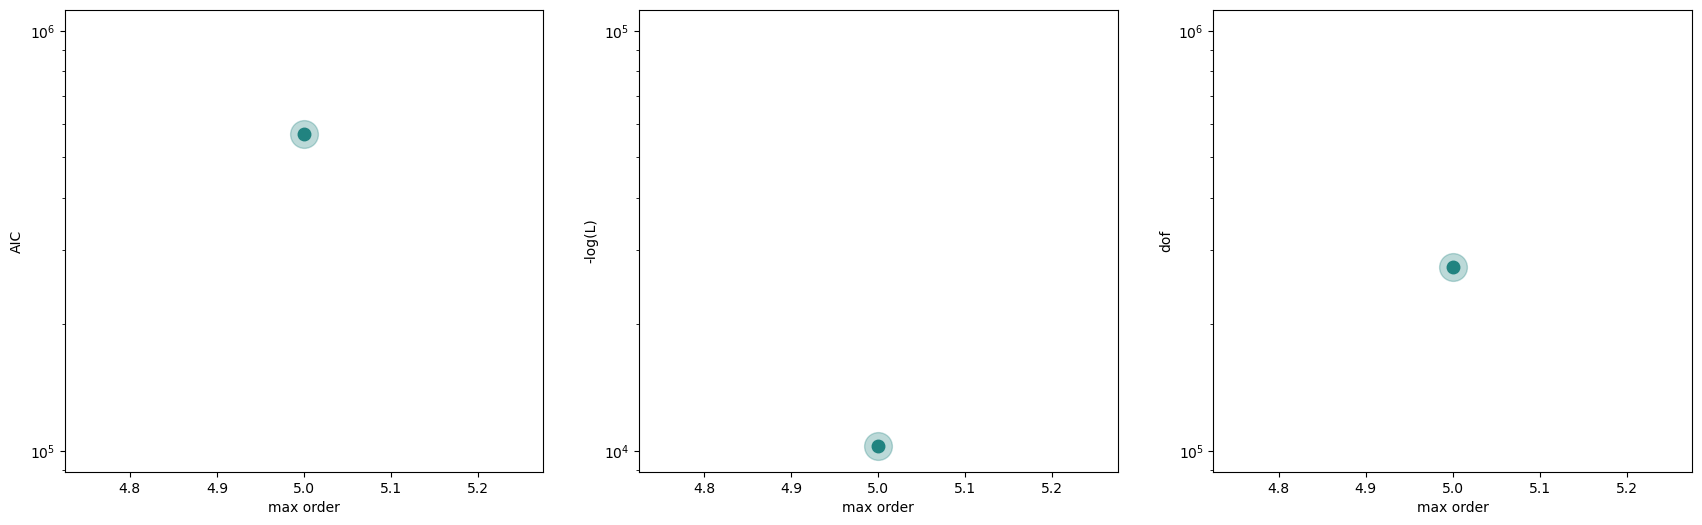

In [8]:
mogen.plot()

In [9]:
training_paths[1]

[130,
 129,
 128,
 4,
 349,
 323,
 388,
 393,
 389,
 414,
 413,
 412,
 411,
 410,
 417,
 419,
 418,
 421,
 420,
 446,
 455,
 459,
 483,
 482,
 481,
 489,
 499,
 501,
 500,
 519,
 523,
 522,
 524,
 533,
 532,
 531,
 530,
 526,
 525,
 516,
 494,
 452,
 454,
 443,
 431,
 168,
 109,
 5,
 300,
 306,
 307,
 304,
 305,
 2,
 269,
 268,
 267,
 270,
 273,
 272,
 264,
 263,
 3,
 348,
 356,
 363,
 362,
 333,
 332,
 328,
 322,
 344]

In [10]:
# make predictions for a start node
predictions = mogen.predict(no_of_paths=1000, max_order=5, start_node=('130', '129','128', '4', '349',))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.10s/it]


In [11]:
sorted_predictions = dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True))
for key, val in sorted_predictions.items():
    if val > 1:
        node_sequence = [int(x) for x in key]
        print(node_sequence, val)

[130, 129, 128, 4, 349, 323, 309, 315, 519, 523, 522, 524] 61
[130, 129, 128, 4, 349, 323, 388, 393, 389, 414, 413, 410, 419, 418, 421, 420, 446] 4
[130, 129, 128, 4, 349, 323, 388, 393, 389, 414, 413, 412, 411, 410, 417, 419, 418, 421, 420, 446, 455, 459, 483, 482, 481, 489, 499, 501, 500, 519, 523, 522, 524, 533, 532, 531, 530, 526, 525, 404, 405, 176, 151, 152, 141, 142] 3
[130, 129, 128, 4, 349, 323, 388, 393, 410, 419, 418, 421, 420, 446, 455, 459, 483, 482, 481, 489, 499, 501, 500, 519, 523, 522, 524, 533, 532, 531, 530, 526, 525, 404, 405, 176, 151, 152, 141, 142] 3
[130, 129, 128, 4, 349, 323, 309, 315, 519, 523, 522, 524, 533, 532, 531, 530, 526, 525, 516, 494, 452, 454, 453, 443, 431] 3
[130, 129, 128, 4, 349, 323, 388, 393, 410, 419, 418, 421, 420, 446, 455, 459, 483, 482, 481, 489, 499, 501, 500, 519, 523, 522, 524, 526, 525, 404, 405, 151, 152, 141, 142] 3
[130, 129, 128, 4, 349, 323, 309, 315, 519, 523, 522, 524, 533, 532, 531, 530, 526, 525, 516, 404, 405, 176, 151, 152,

In [14]:
# plot network and basemap
map = network.map_graph(pruned=True, min_passages=3, center=[69, 19])  #tromso: center=[69, 19]

# plot prediction and ground truth
selection = [1]
for i in selection:
    mmsi = training_data['mmsi'].iloc[i]
    predicted_path = [130, 129, 128, 4, 349, 323, 388, 393, 389, 414, 413, 412, 411, 410, 417, 419, 418, 421, 420, 446, 455, 459, 483, 482, 481, 489, 499, 501, 500, 519, 523, 522, 524, 533, 532, 531, 530, 526, 525, 404, 405, 176, 151, 152, 141, 142]
    true_path = training_paths[1]
    true_path_line = geometry_utils.get_geo_df(true_path, network.waypoint_connections)
    predicted_path_line = geometry_utils.get_geo_df(predicted_path, network.waypoint_connections)
    #predicted_path_line['SSPD'] = eval_results['SSPD'].iloc[i]
    trajectory = network.trajectories.get_trajectory(mmsi).to_line_gdf()

    map = trajectory[['mmsi', 'geometry', 'skipsgruppe', 'length', 'bredde']].explore(m=map, style_kwds={'weight':3, 'color':'black', 'opacity':1},
                                                                                      name=f'{mmsi} trajectory')
    map = true_path_line.explore(m=map, style_kwds={'weight':3, 'color':'cyan', 'opacity':1},
                               name=f'{mmsi} closest path')
    map = predicted_path_line.explore(m=map, style_kwds={'weight':3, 'color':'yellow', 'opacity':1},
                                   name=f'{mmsi} prediction')
    
folium.LayerControl().add_to(map)
map.save('../../reports/maps/'+model_name+'_predictions_MOGen.html')